In [1]:
# impoorting libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# loading data
data = pd.read_csv("../../cleaned_rwanda_crops_dataset.csv")
# checking data
data.head()
data.info()
data.describe()
data.isnull().sum()
data.duplicated().sum()             

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   N                       200 non-null    float64
 1   P                       200 non-null    float64
 2   K                       200 non-null    float64
 3   temperature             200 non-null    float64
 4   humidity                200 non-null    float64
 5   ph                      200 non-null    float64
 6   rainfall                200 non-null    float64
 7   elevation               200 non-null    float64
 8   slope                   200 non-null    float64
 9   aspect                  200 non-null    float64
 10  water_holding_capacity  200 non-null    float64
 11  wind_speed              200 non-null    float64
 12  solar_radiation         200 non-null    float64
 13  ec                      200 non-null    float64
 14  zn                      200 non-null    fl

np.int64(0)

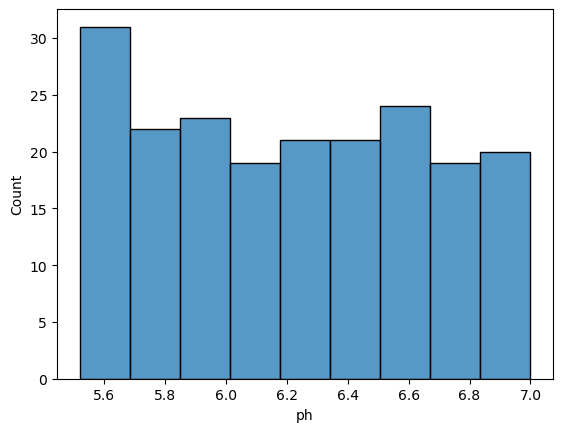

In [3]:
# visualizing PH distribution
sns.histplot(data['ph'])
plt.show()

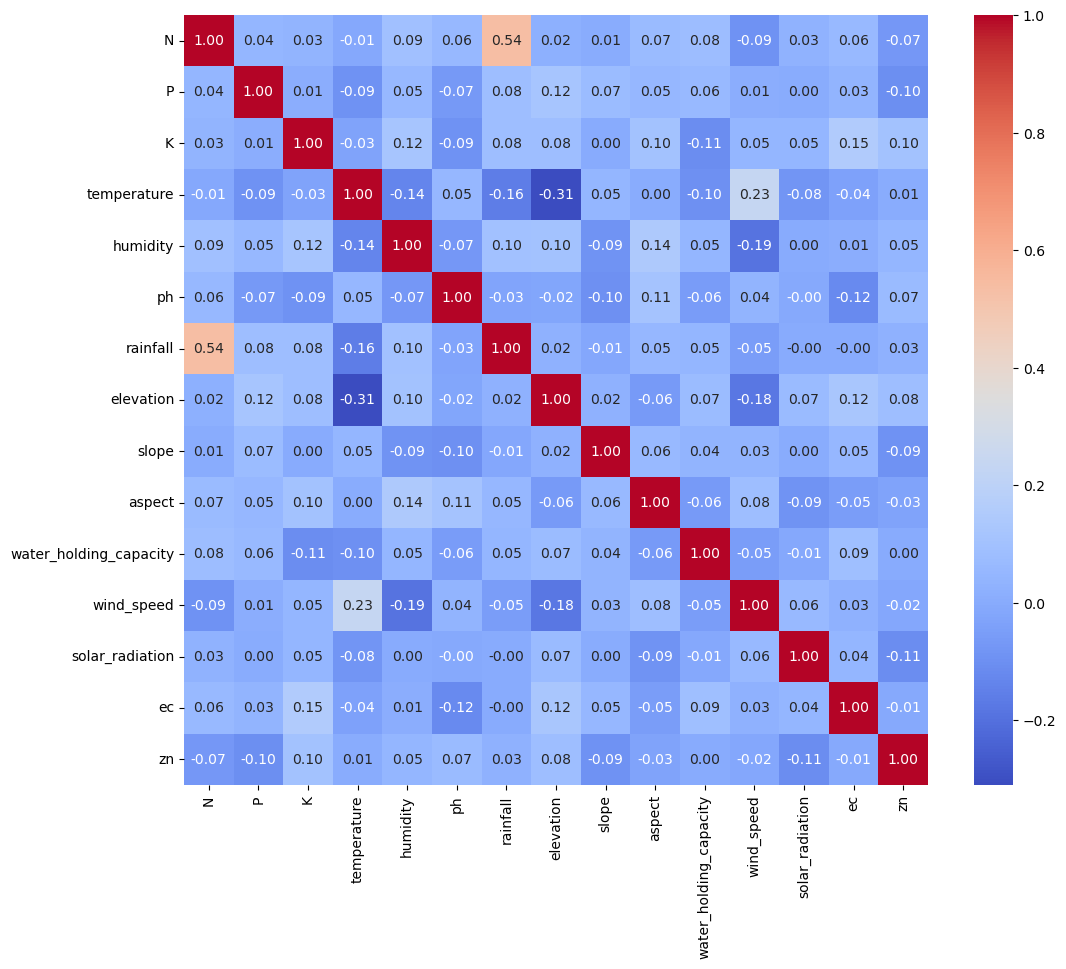

In [4]:

# correlation heatmap

plt.figure(figsize=(12, 10))
sns.heatmap(data.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

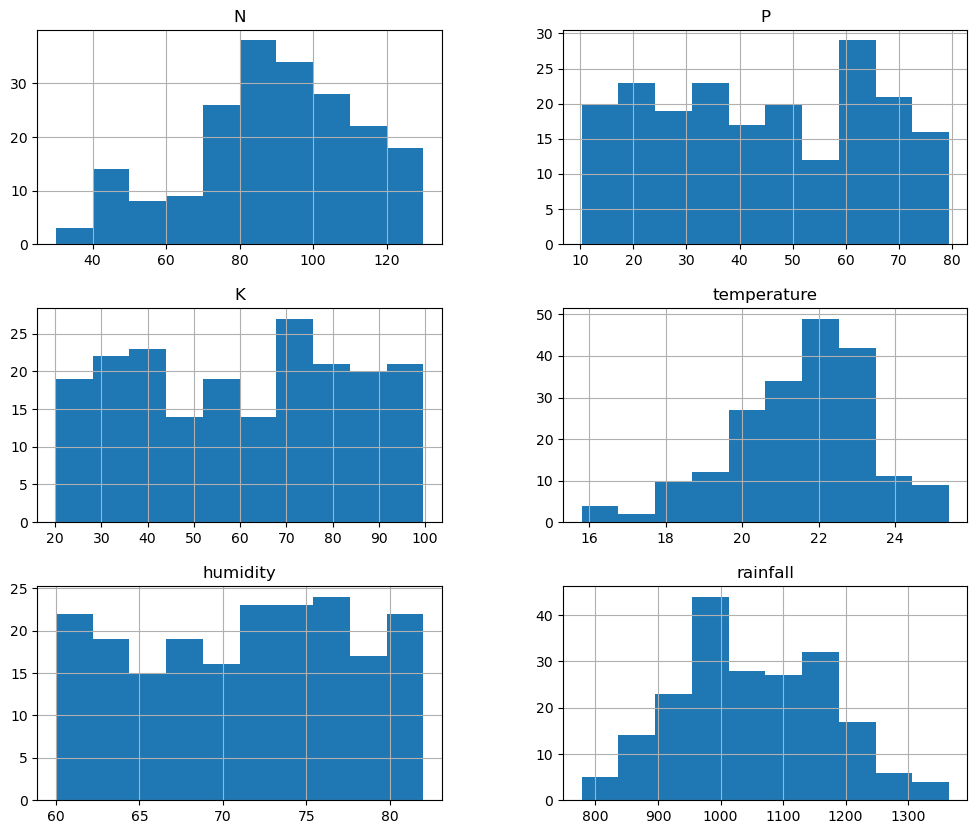

In [5]:
# variable distribution
data[['N', 'P', 'K', 'temperature', 'humidity', 'rainfall']].hist(figsize=(12, 10))
plt.show()

In [6]:
data = pd.get_dummies(data, columns=["soil_texture"], drop_first=True)

Index(['N', 'P', 'K', 'temperature', 'humidity', 'rainfall', 'elevation',
       'slope', 'aspect', 'water_holding_capacity', 'wind_speed',
       'solar_radiation', 'ec', 'zn', 'soil_texture_Loam',
       'soil_texture_Sandy', 'soil_texture_Sandy Clay',
       'soil_texture_Sandy Loam'],
      dtype='object')


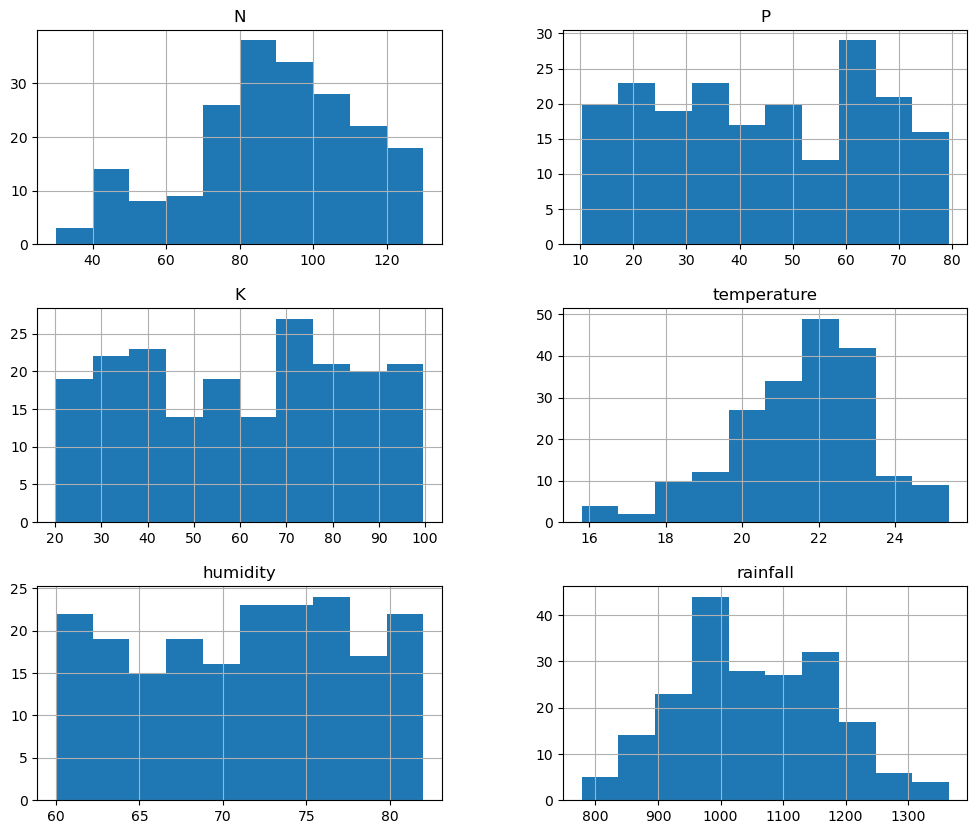

In [ ]:
X = data.drop("ph", axis=1)
X = X.drop("label", axis = 1)
y = data["ph"]
X
print(X.columns) 


X[
    [
        'N', 'P', 'K', 'temperature', 'humidity', 'rainfall',
        'soil_texture_Loam', 'soil_texture_Sandy', 'soil_texture_Sandy Clay',
        'soil_texture_Sandy Loam'
    ]
].hist(figsize=(12, 10))
plt.show()

In [8]:
# Scale Numerical Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
#Save the Scaler
joblib.dump(scaler, 'scaler.joblib')

X_train shape: (160, 18)
X_test shape: (40, 18)
y_train shape: (160,)
y_test shape: (40,)


['scaler.joblib']

Linear Train MSE: 0.16703902181910682
Linear Test MSE: 0.23035857609245158


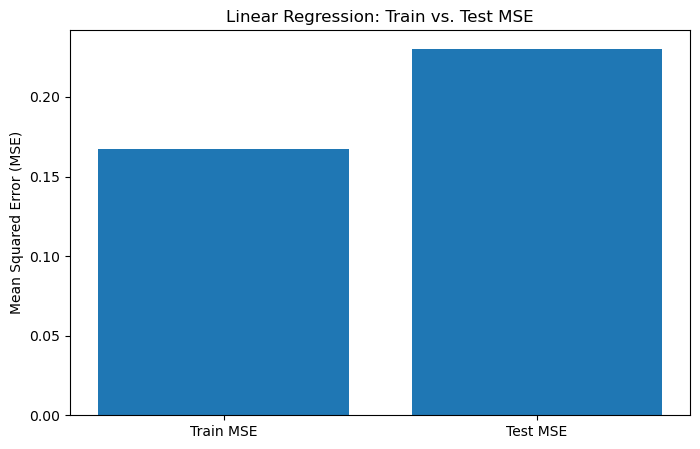

In [15]:


linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_predictions = linear_model.predict(X_test)
linear_mse = mean_squared_error(y_test, linear_predictions)

train_predictions = linear_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)

print(f"Linear Train MSE: {train_mse}")
print(f"Linear Test MSE: {linear_mse}")

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(['Train MSE', 'Test MSE'], [train_mse, linear_mse])
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Linear Regression: Train vs. Test MSE')
plt.show()

Tree Train MSE: 0.11114049535024155
Tree Test MSE: 0.29290885044169124


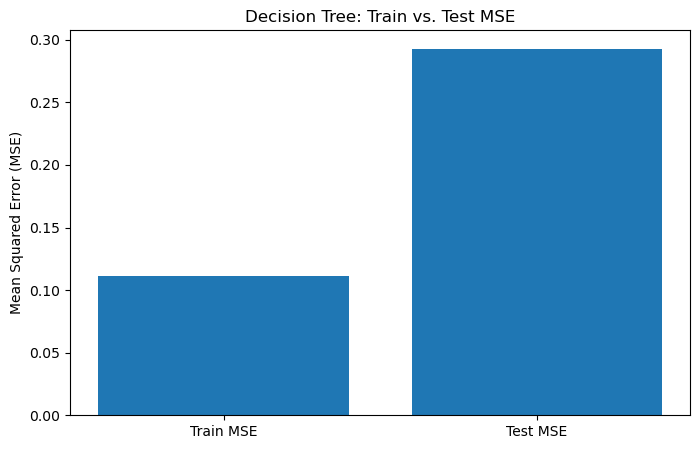

In [ ]:


tree_model = DecisionTreeRegressor(max_depth=5)  
tree_model.fit(X_train, y_train)
tree_predictions = tree_model.predict(X_test)
tree_mse = mean_squared_error(y_test, tree_predictions)

# Calculate training MSE
tree_train_predictions = tree_model.predict(X_train)
tree_train_mse = mean_squared_error(y_train, tree_train_predictions)

print(f"Tree Train MSE: {tree_train_mse}")
print(f"Tree Test MSE: {tree_mse}")

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(['Train MSE', 'Test MSE'], [tree_train_mse, tree_mse])
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Decision Tree: Train vs. Test MSE')
plt.show()

Forest Train MSE: 0.0771231952432339
Forest Test MSE: 0.21730493331724365


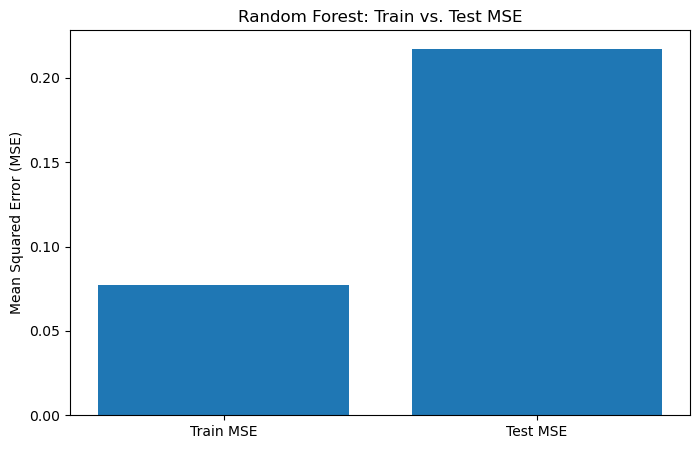

In [ ]:



# Adjust hyperparameters to minimize overfitting
forest_model = RandomForestRegressor(
    max_depth=10,        
    min_samples_leaf=5,  
    min_samples_split=10, 
    random_state=42       
)

forest_model.fit(X_train, y_train)
forest_predictions = forest_model.predict(X_test)
forest_mse = mean_squared_error(y_test, forest_predictions)

# Calculate training MSE
forest_train_predictions = forest_model.predict(X_train)
forest_train_mse = mean_squared_error(y_train, forest_train_predictions)

print(f"Forest Train MSE: {forest_train_mse}")
print(f"Forest Test MSE: {forest_mse}")

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(['Train MSE', 'Test MSE'], [forest_train_mse, forest_mse])
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Random Forest: Train vs. Test MSE')
plt.show()

In [ ]:
best_model = None
best_mse = None
best_model_name = None  

if linear_mse < tree_mse and linear_mse < forest_mse:
    best_model = linear_model
    best_mse = linear_mse
    best_model_name = "Linear Regression"
elif tree_mse < linear_mse and tree_mse < forest_mse:
    best_model = tree_model
    best_mse = tree_mse
    best_model_name = "Decision Tree"
else:
    best_model = forest_model
    best_mse = forest_mse
    best_model_name = "Random Forest"

joblib.dump(best_model, "best_ph_model.joblib")
print(f"Best Model: {best_model_name}, MSE: {best_mse}")

Best Model: Random Forest, MSE: 0.21730493331724365


/home/chris/miniconda3/envs/soil_ph_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Example prediction: 6.273830053973807


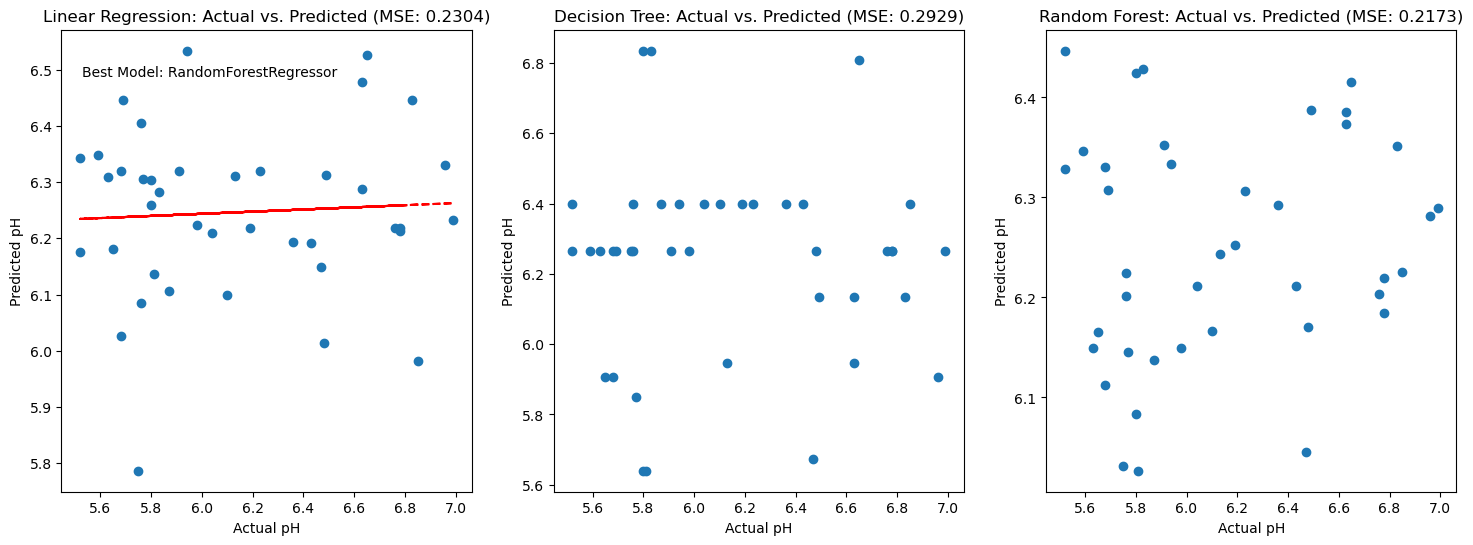

In [ ]:
import matplotlib.pyplot as plt
import numpy as np  # Import NumPy

def predict_ph(input_data):
    model = joblib.load("best_ph_model.joblib")
    scaler = joblib.load('scaler.joblib')
    scaled_input = scaler.transform(input_data)
    prediction = model.predict(scaled_input)
    return prediction[0]

example_input = X_test.iloc[[0]]
example_prediction = predict_ph(example_input)
print(f"Example prediction: {example_prediction}")

# Scatter Plots for each model.
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(y_test, linear_predictions)
plt.xlabel("Actual pH")
plt.ylabel("Predicted pH")
plt.title(f"Linear Regression: Actual vs. Predicted (MSE: {linear_mse:.4f})")

# Add line of best fit for Linear Regression
z = np.polyfit(y_test, linear_predictions, 1)  # Fit a 1st-degree polynomial (line)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), "r--")  # the line of best fit
plt.annotate(f"Best Model: {best_model.__class__.__name__}", xy=(0.05, 0.9), xycoords='axes fraction')

plt.subplot(1, 3, 2)
plt.scatter(y_test, tree_predictions)
plt.xlabel("Actual pH")
plt.ylabel("Predicted pH")
plt.title(f"Decision Tree: Actual vs. Predicted (MSE: {tree_mse:.4f})")

plt.subplot(1, 3, 3)
plt.scatter(y_test, forest_predictions)
plt.xlabel("Actual pH")
plt.ylabel("Predicted pH")
plt.title(f"Random Forest: Actual vs. Predicted (MSE: {forest_mse:.4f})")

plt.show()